In [1]:
## GET THE TEXT
from xml.dom import minidom
import numpy as np
import copy
import re

# CLUSTER THE REACTIONS USING DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

## THINGS FOR RDIKIT (Not everything is needed)
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=0.015
from rdkit.Chem import AllChem
from IPython.display import display, SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D 
import pybel

## THIS IS JUST TO OUTPUT ASCII TABLES
from prettytable import PrettyTable

In [1]:
def getmoleculescenters(mydoc):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    items = mydoc.getElementsByTagName('fragment')
    tt=[np.fromstring(elem.getAttribute("BoundingBox"), dtype=np.float, sep=' ' ).tolist() for elem in items]
    
    # get the center of the frame
    return np.asarray([[(i[0]+i[2])/2,(i[1]+i[3])/2] for i in tt])

def getmaxyframe(mydoc):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    items = mydoc.getElementsByTagName('fragment')
    tt=[np.fromstring(elem.getAttribute("BoundingBox"), dtype=np.float, sep=' ' ).tolist() for elem in items]
    
    # get the center of the frame
    return np.max([i[3] for i in tt ])

def getmolyrange(mydoc,idx):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    items = mydoc.getElementsByTagName('fragment')
    tt=[np.fromstring(elem.getAttribute("BoundingBox"), dtype=np.float, sep=' ' ).tolist() for elem in items]
    
    # get the center of the frame
    return [np.asarray([i[1],i[3]]) for idm,i in enumerate(tt) if idm==idx][0]

def getmolxrange(mydoc,idx):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    items = mydoc.getElementsByTagName('fragment')
    tt=[np.fromstring(elem.getAttribute("BoundingBox"), dtype=np.float, sep=' ' ).tolist() for elem in items]
    
    # get the center of the frame
    return [np.asarray([i[0],i[2]]) for idm,i in enumerate(tt) if idm==idx][0]


def getarrowcenter(boundingbox):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    i=np.fromstring(boundingbox, dtype=np.float, sep=' ' ).tolist()
    
    # get the center of the frame
    return np.asarray([(i[0]+i[2])/2,(i[1]+i[3])/2])

def getmoleculesids(mydoc):
    # pass the result of mydoc = minidom.parse('test/287b_overview.cdxml')
    items = mydoc.getElementsByTagName('fragment')
    tt=[elem.getAttribute("id") for elem in items]
    
    return tt

def getcenterobjects(items):
    # given a list of items print the position as an array of floats
    tt=[np.fromstring(elem.getAttribute("p"), dtype=np.float, sep=' ' ).tolist() for elem in items]
    
    return tt

def findattributes(ltexts,tstr):
    # get a list of strings and return the indexes of the cells where
    # tstr is contained
    # EVERYTHING IS CONVERTER TO LOWER CASE
    wordlist=ltexts.copy()
    word = tstr.lower()
    wordlist = [i.lower() for i in wordlist]
    l=[]
    for position,w in enumerate(wordlist):
        if w == word:
            l.append(position)

    if len(l)>0:
        return np.asarray(l)
    else:
        return None
    
def split_str(s):
    return [ch for ch in s]

def getarrowslist(mydoc):
    # GET THE ARROWS AND THE TEXT COMING
    items = mydoc.getElementsByTagName('arrow')
    # get the center of an arrow
    tposarr=np.asarray([getarrowcenter(elem.getAttribute("BoundingBox")) for elem in items])
    
    # GET TEXT FROM THE XML AND ASSOCIATE IT TO THE ARROWS
    
    # GET THE TEXTS ATTRIBUTES + THEIR IDss
    items = mydoc.getElementsByTagName('t')
    # id of each strings extracted from the cdxml
    texts = [(elem.firstChild).firstChild.data for elem in items]
    texts_ids=np.transpose([texts,np.asarray([elem.getAttribute("id") for elem in items])])
    
    ## GET REACTION PARAMETERS (WHAT IS BELOW AN ARROW)
    items = mydoc.getElementsByTagName('step')
    react_steps=[np.fromstring(elem.getAttribute("ReactionStepObjectsBelowArrow"), dtype=np.int, sep=' ' ).tolist() for elem in items]
    
    ## GENERATE THE DICTIONARIES
    tlr=[]
    for c,k in enumerate(tposarr):
        tlr.append({}.fromkeys(['temperature','yield','length','center'], 0))
        tlr[c]['center']=k
        tlr[c]['temperature']=None
        tlr[c]['yield']=None
        tlr[c]['length']=None
        
        
    ## FILL THE DICTIONARIES
    for i,v in enumerate(tposarr):
        for j in react_steps[i]:
            tstr=texts_ids[:,0][texts_ids[:,1].tolist().index(str(j))]
            spltstr=split_str(tstr)
            if (spltstr[-1]=='K' or spltstr[-1]=='C'):
                tlr[i]['temperature']=tstr
            if spltstr[-1]=='%':
                tlr[i]['yield']=tstr
            if ((spltstr[0]=='<' and spltstr[1]=='L') or (spltstr[0]=='L')):
                
                try:
                    # REGEX TO GET A PATTERN BEFOR AND AFTER THE CHAR _
                    # SAVE ONLY THE GROUP AFTER _
                    pattern=re.match("(.*=)(.*)",tstr).group(2)
                    tlr[i]['length']=pattern
                except:
                    # IF THE CHAR _ IS NOT PRESENT, WRITE '0'
                    pattern='0'
        
    return tlr

def getmolslist(mydoc):
    ## GET THE MOLECULE CENTERS
    lc=getmoleculescenters(mydoc)
    # Create list of dictionaries of the length of the number of molecules
    lmol_dic=[]
    lmol_ids=getmoleculesids(mydoc)
    for i,c in enumerate(lc):
        lmol_dic.append({}.fromkeys(['center','name','unique','products','smile','id'], 0))
        lmol_dic[i]['center']=c
        lmol_dic[i]['unique']=1
        lmol_dic[i]['products']=None
        lmol_dic[i]['smile']=''
        lmol_dic[i]['id']=lmol_ids[i]

    ## GET ALL THE TEXT TAGS AND FIND THE CLOSEST MOLECULE
    items = mydoc.getElementsByTagName('t')
    # list of strings extracted from the cdxml
    texts = [(elem.firstChild).firstChild.data for elem in items]
    # assignt to each string the closest fragment
    ptexts = np.asarray([ 
        np.argmin([np.linalg.norm(j['center']-np.fromstring( elem.getAttribute("p"), dtype=np.float, sep=' ' )) for j in lmol_dic]) 
        for elem in items])

    # check if there are Non unique molecules and
    # set the proper flag in the dictionary
    try:
        # if there are some Non unique molecules
        for i in findattributes(texts,'Non unique'):
            lmol_dic[ptexts[i]]['unique']=0
    except:
        None
    
    # assign the proper name to each molecule
    for im in [i for i,s in enumerate(texts) if 'name' in s.lower()]:
        lmol_dic[ptexts[im]]['name']=texts[im][5:len(texts[im])]
        
    return lmol_dic

def show(mol,molSize=(475,175),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    assert mc.GetNumConformers() > 0
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    #drawer.bondLineWidth=0.005
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))
    
    
def getsmilesfromcdxml(filecdxml, lmolecules):
    # SMILES ARE EXTRACTED ACCORDING TO THE ID OF THE FRAGMENTS
    # so i have first to sort the molecules IDs before associating the corresponding smile
    odersmiles=np.argsort(np.asarray([int(i['id']) for i in lmolecules]))
    for i,mol in enumerate(pybel.readfile("cdxml", testfile)):
        # print(mol.formula,mol.molwt,len(mol.OBMol.GetSSSR()),lmolecules[odersmiles[i]]['name'])
        smile=mol.write("smi")
        # remove tabs and number of atoms
        smile=re.sub(r'\t.*', '', smile, flags=re.M).strip()
        # UPDATE THE MOL DICTIONARIES WITH THE SMILES
        lmolecules[odersmiles[i]]['smile']=smile
        # MAKE IT CANONICAL USING BABEL
        # tsm=pybel.readstring("smi", smile).write("can")
    
    ##### CHECK THE SVG
    ###tmpl = Chem.MolFromSmiles(smile)
    ###AllChem.Compute2DCoords(tmpl)
    ###show(tmpl,molSize=(375,75))
    ###print("SMILE:  ",smile,"\n")
    ####3D VIEWR
    ###imolecule.draw(smile)
    ###print("SMILE:  ",smile,"\n")
    

## NEW FUNTIONS

def minmax(tmpv):
    return np.asarray([np.min(tmpv),np.max(tmpv)])

def getgridDBSCAN(lmol_dic):
    x=np.asarray([i['center'] for i in lmol_dic])[:,0]
    y=np.asarray([i['center'] for i in lmol_dic])[:,1]
    #fake a 2d space to avoid erros
    fakex=np.asarray([x,np.zeros((len(x)),dtype=float)]).T
    #lets scale to avoid having to play much with the parameters of dbscan
    fakex = StandardScaler().fit_transform(fakex)
    dbx = DBSCAN(eps=0.3, min_samples=1).fit(fakex)
    labelsx = dbx.labels_
    
    return [np.where(labelsx==i)[0] for i in range(len(set(labelsx)))]
    
def getreactions(mydoc,lmolecules,larrows):
    # GET THE REACTION LISTS GIVEN THE document, molecules, arrows
    tr=getgridDBSCAN(lmolecules)
    #sort it accoring to the y
    tr=[i[np.argsort([lmolecules[j]['center'][1] for j in i])] for i in tr]

    ## GUESS THE POSSIBLE REACTION FROM THE POSITIONS IN THE FRAME
    lreac_dic=[]
    c=-1

    for i in range(len(tr)-1):
        # REACTANTS
        for j,mr in enumerate(tr[i]):
            # LOOP WITHIN THE REACTANTS
            # GET THE Y-RANGE TO UNDRSTAND HOW TO LINK PRODUCTS WITH REACTANTS
            rymr=np.zeros((2),dtype=float)
            if (j==0):
                # I am the first of the list
                # set the beginning of the reaction range
                rymr[0]=0
            else:
                # reactions of the next x-layer start at this y 
                rymr[0]=getmolyrange(mydoc,mr)[0]
            if ((j+1)==len(tr[i])):
                # I am the last of the list
                # set the end of the reaction range
                # it is the end of the whole frame in this case since I am the last molecule
                rymr[1]=getmaxyframe(mydoc)
            else:
                # reactions of the next x-layer end at the y of next molecule in my x-layer
                rymr[1]=getmolyrange(mydoc,tr[i][j+1])[0]
            for k,mp in enumerate(tr[i+1]):
                if (rymr[0]<lmolecules[mp]['center'][1]<rymr[1]):
                    c=c+1
                    print(lmolecules[mr]['name']+">"+lmolecules[mp]['name'])
                    lreac_dic.append({}.fromkeys(['label','reactant','product','temperature','yield','length'], 0))
                    lreac_dic[c]['label']=lmolecules[mr]['name']+">"+lmolecules[mp]['name']
                    lreac_dic[c]['reactant']=lmolecules[mr]['name']
                    lreac_dic[c]['product']=lmolecules[mp]['name']
                
                    # GET THE CORRESPONDING ARROW
                
                    # get y-range for this product
                    prodyrange=getmolyrange(mydoc,mp)
                    for lm in larrows:
                        if (prodyrange[0]<lm['center'][1]<prodyrange[1]):
                            # get x-range for this product
                            prodxrange=getmolxrange(mydoc,mp)
                            # only slect the arrow on the left of the prduct
                            if (prodxrange[0]>lm['center'][0]):
                                # OK, COPY THE ATTRIBUTES
                                lreac_dic[c]['temperature']=lm['temperature']
                                lreac_dic[c]['yield']=lm['yield']
                                lreac_dic[c]['length']=lm['length']

    
                    # update products list in the molecule dictionaries
                    for lm in lmolecules:
                        if lm['name']==lreac_dic[c]['reactant'] :
                            if lm['products']==None:
                                lm['products']=[] 
                            lm['products'].append(lreac_dic[c]['products'])
                            
    return lreac_dic
    

def parsecdxml(tfile):
    # GET THE LIST OF MOLECULES AND REACTIONS
    mydoc = minidom.parse(tfile)
    lmolecules=getmolslist(mydoc)
    larrows=getarrowslist(mydoc)
    lreactions=getreactions(mydoc,lmolecules,larrows)
    
    return lmolecules,lreactions
    

# TEST EXTRACTION

In [3]:
# PARSE THE CDXML AND GET ALL THE REACTIONS AND MOLECULES
testfile="big_test.cdxml"
lmolecules,lreactions = parsecdxml(testfile)

223c>223c_1a
223c>223c_1b
223c>223c_1c
223c_1a>223c_2a
223c_1a>223c_2b
223c_1b>223c_2c
223c_1c>223c_2d
223c_1c>223c_2e


# TEST RDIKIT and BABEL

223c


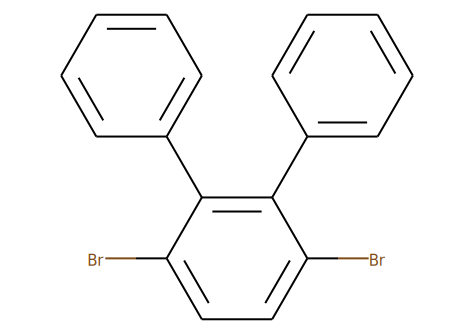

223c_1a


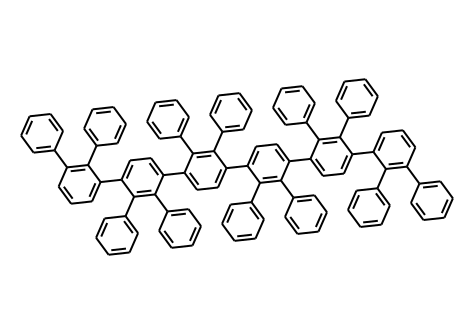

223c_2a


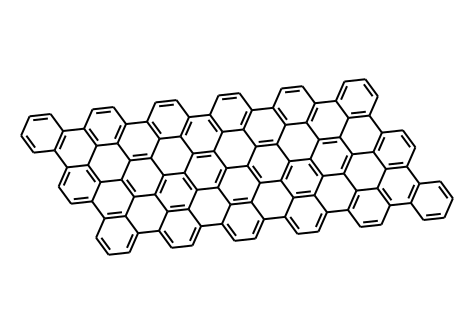

223c_2b


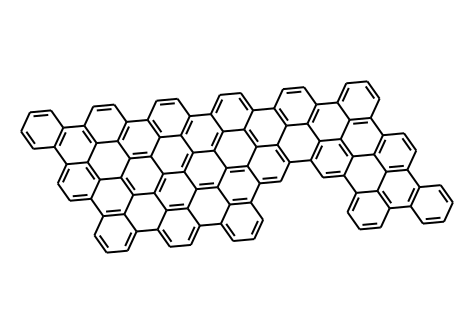

223c_2c


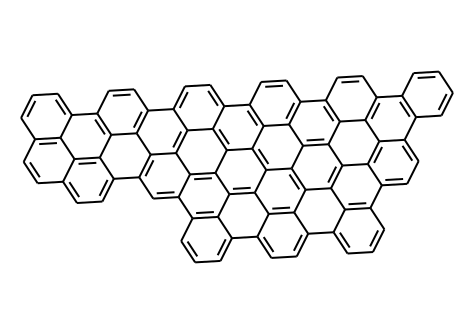

223c_1c


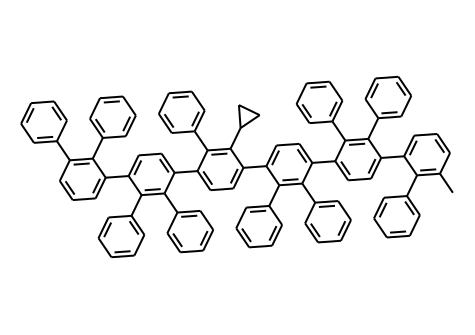

223c_2d


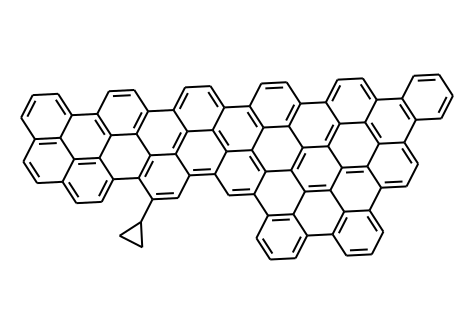

223c_2e


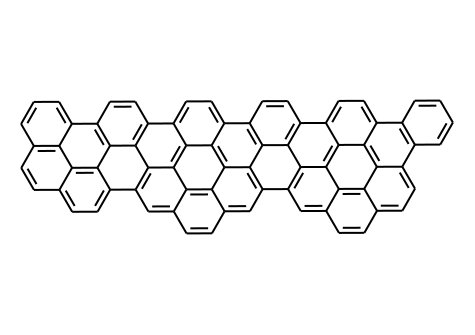

223c_1b


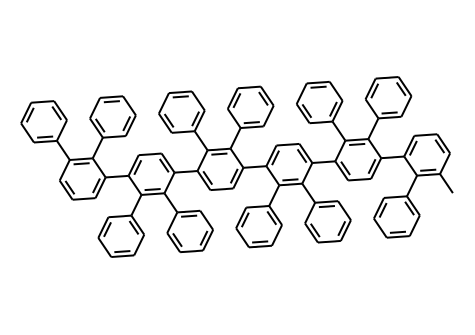

+----------+---------+-------------+-------+--------+
| Reactant | Product | Temperature | Yield | Length |
+----------+---------+-------------+-------+--------+
|   223c   | 223c_1a |     450K    |  96%  |  None  |
|   223c   | 223c_1b |     90K     |   1%  |  15nm  |
|   223c   | 223c_1c |    1000K    |   3%  |  None  |
| 223c_1a  | 223c_2a |     600K    |  70%  |  15nm  |
| 223c_1a  | 223c_2b |     670K    |  100% |  15nm  |
| 223c_1b  | 223c_2c |     90K     |   1%  |  15nm  |
| 223c_1c  | 223c_2d |    1000K    |   3%  |  None  |
| 223c_1c  | 223c_2e |    1222K    |  100% |  15nm  |
+----------+---------+-------------+-------+--------+


In [5]:
# GET THE SMILES
getsmilesfromcdxml(testfile, lmolecules)

# PRINT OUT A SUMMARY
from prettytable import PrettyTable
    
    
## CHECK THE SVG
for j in lmolecules:
    print(j['name'])
    tmpl = Chem.MolFromSmiles(j['smile'])
    AllChem.Compute2DCoords(tmpl)
    show(tmpl,molSize=(475,335))
    
x = PrettyTable()

x.field_names = ["Reactant", "Product", "Temperature", "Yield","Length"]

for i in lreactions:
    x.add_row([i['reactant'],i['product'], i['temperature'], i['yield'],i['length']])
    
print(x)